In [89]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

In [31]:
df_leagues = pd.read_csv('../data/csv/Leagues.csv', index_col=0)

df_leagues.drop(['date', 'league', 'matchweek', 'home_team_id', 'away_team_id', 'home_team', 'away_team', 'home_manager', 'away_manager'], axis=1, inplace=True)
print(f'Nb NaN: {df_leagues.isna().sum().sum()}')

df_leagues['home_team_form'] = df_leagues['home_team_form'].fillna('')
df_leagues['home_team_home_form'] = df_leagues['home_team_home_form'].fillna('')
df_leagues['home_team_average_goals_form'] = df_leagues['home_team_average_goals_form'].fillna(0)
df_leagues['home_team_average_xg_form'] = df_leagues['home_team_average_xg_form'].fillna(0)
df_leagues['home_team_average_goals_form_against'] = df_leagues['home_team_average_goals_form_against'].fillna(0)
df_leagues['home_team_average_xg_form_against'] = df_leagues['home_team_average_xg_form_against'].fillna(0)
df_leagues['away_team_form'] = df_leagues['away_team_form'].fillna('')
df_leagues['away_team_away_form'] = df_leagues['away_team_away_form'].fillna('')
df_leagues['away_team_average_goals_form'] = df_leagues['home_team_average_goals_form'].fillna(0)
df_leagues['away_team_average_xg_form'] = df_leagues['home_team_average_xg_form'].fillna(0)
df_leagues['away_team_average_goals_form_against'] = df_leagues['home_team_average_goals_form_against'].fillna(0)
df_leagues['away_team_average_xg_form_against'] = df_leagues['home_team_average_xg_form_against'].fillna(0)

print(f'Nb NaN: {df_leagues.isna().sum().sum()}')
df_leagues.head()

Nb NaN: 1276
Nb NaN: 0


,home_formation,home_goals,home_xg,away_xg,away_goals,away_formation,home_team_form,home_team_league_pos,home_team_points_diff,home_team_home_form,...,away_team_form,away_team_league_pos,away_team_points_diff,away_team_away_form,away_team_away_league_pos,away_team_away_points_diff,away_team_average_goals_form,away_team_average_xg_form,away_team_average_goals_form_against,away_team_average_xg_form_against
0,4-2-3-1,1,2.4,0.4,0,4-2-3-1,,1.0,0,,...,,1.0,0,,1.0,0,0.000000,0.000000,0.000000,0.000000
1,4-2-3-1,1,0.8,1.7,3,4-2-3-1,DDLWW,14.0,6,LDW,...,WDLDW,7.0,-2,WDD,2.0,2,1.000000,0.633333,1.000000,1.533333
2,4-2-3-1,1,1.0,1.2,1,4-3-3,,1.0,0,,...,,1.0,0,,1.0,0,0.000000,0.000000,0.000000,0.000000
3,4-2-3-1,2,1.3,0.6,1,4-2-3-1,WWLLD,10.0,-12,DWL,...,LDWLW,8.0,1,LLL,19.0,0,1.666667,1.833333,1.666667,1.300000
4,4-2-3-1,1,1.7,1.0,0,3-1-4-2,DWDLD,9.0,-2,DDL,...,DDDLL,18.0,-1,LDL,17.0,-2,0.666667,1.033333,1.000000,1.066667


In [ ]:
def get_train_test_split(df_leagues: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.Series, pd.Series):
    df_train, df_test = train_test_split(df_leagues, test_size=0.2, random_state=42)
    #df_train, df_val = train_test_split(df_full_train, test_size=len(df_leagues) * 0.2 / len(df_full_train), random_state=42)

    y_train = df_train['home_goals']
    #y_val = df_val['home_goals']
    y_test = df_test['home_goals']

    del df_train['home_goals']
    #del df_val['home_goals']
    del df_test['home_goals']
    
    return df_train, df_test, y_train, y_test



In [74]:
df_train, df_test, y_train, y_test = get_train_test_split(df_leagues)
df_train.head()

,home_formation,home_xg,away_xg,away_goals,away_formation,home_team_form,home_team_league_pos,home_team_points_diff,home_team_home_form,home_team_home_league_pos,...,away_team_form,away_team_league_pos,away_team_points_diff,away_team_away_form,away_team_away_league_pos,away_team_away_points_diff,away_team_average_goals_form,away_team_average_xg_form,away_team_average_goals_form_against,away_team_average_xg_form_against
328,4-2-3-1,1.2,1.6,1,4-4-2,WWLLW,6.0,-3,LW,14.0,...,LWLLW,11.0,3,WL,6.0,2,1.000000,1.600000,3.500000,2.050000
17,4-3-3,1.0,1.1,0,3-4-3,DLDWD,7.0,-5,WDW,9.0,...,DLWWW,10.0,9,LLW,13.0,-3,2.333333,2.433333,1.333333,1.466667
97,3-4-3,0.9,0.4,2,4-3-3,DDLWL,13.0,-7,DLW,14.0,...,LLWDL,14.0,-5,LD,6.0,2,1.000000,1.333333,1.000000,0.500000
41,3-4-3,1.4,0.6,1,3-4-1-2,WLLW,7.0,0,WW,7.0,...,WWDD,4.0,-4,WD,7.0,0,3.000000,1.650000,0.000000,1.200000
286,3-4-3,1.2,0.3,0,4-2-3-1,DWL,9.0,-2,W,4.0,...,DWL,9.0,-2,W,6.0,1,2.000000,2.200000,0.000000,1.100000


In [87]:
dict_vectorizer = DictVectorizer(sparse=False)

train_serie_dict = df_train.to_dict(orient='records')
test_serie_dict = df_test.to_dict(orient='records')
X_train = dict_vectorizer.fit_transform(train_serie_dict)
X_test = dict_vectorizer.transform(test_serie_dict)

In [88]:
df_results = pd.DataFrame(columns={'max_depth': [], 'rmse': [], 'mae': [], 'r2': []})

def train_decision_tree_model(max_depth: int) -> DecisionTreeRegressor:
    decision_tree_model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    decision_tree_model.fit(X_train, y_train)
    
    y_home_test_pred = decision_tree_model.predict(X_test)
    
    rmse = root_mean_squared_error(y_test, y_home_test_pred)
    mae = mean_absolute_error(y_test, y_home_test_pred)
    r2 = r2_score(y_test, y_home_test_pred)
    
    return rmse, mae, r2

for max_depth in tqdm(range(1, 10)):
    rmse, mae, r2 = train_decision_tree_model(max_depth)
    
    df_temp = pd.DataFrame([{'max_depth': max_depth, 'rmse': rmse, 'mae': mae, 'r2': r2}])
    df_results = pd.concat([df_results, df_temp], ignore_index=True)

df_results

  0%|          | 0/9 [00:00<?, ?it/s]

/var/folders/x9/t16jfwq91z735wm10ntxvh780000gq/T/ipykernel_54108/2054819219.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, df_temp], ignore_index=True)


,max_depth,rmse,mae,r2
0,1,1.121526,0.907857,0.256530
1,2,1.026887,0.835718,0.376710
2,3,1.011334,0.805790,0.395447
3,4,1.021003,0.817499,0.383832
4,5,1.014446,0.810292,0.391721
5,6,1.047284,0.819271,0.351703
6,7,1.056740,0.812144,0.339943
7,8,1.116430,0.860832,0.263271
8,9,1.158487,0.894672,0.206719


In [83]:

df_leagues_copy = df_leagues.copy()
y = df_leagues_copy['home_goals']
del df_leagues_copy['home_goals']

serie_dict = df_leagues_copy.copy().to_dict(orient='records')
X = dict_vectorizer.fit_transform(serie_dict)

param_grid = {
    'max_depth': range(1, 10),
    'min_samples_split': range(1, 10, 2),
    'min_samples_leaf': range(1, 8, 2),
    'max_features': [None, 'sqrt', 'log2']
}

scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']

grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring=scoring, refit='r2')
grid_search.fit(X, y)
best_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (R2):", grid_search.best_score_)

Best parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 3}
Best cross-validation score (R2): 0.30782822340412086


/Users/florian/Workspace/Learning/ml_zoomcamp/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 2700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/florian/Workspace/Learning/ml_zoomcamp/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/florian/Workspace/Learning/ml_zoomcamp/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~

In [90]:
random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train, y_train)

y_home_test_pred = random_forest_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_home_test_pred)
mae = mean_absolute_error(y_test, y_home_test_pred)
r2 = r2_score(y_test, y_home_test_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

RMSE: 0.9713584008269773
MAE: 0.7804285714285714
R²: 0.44229591598247875


In [ ]:
param_grid = {
    'n_estimators': range(10, 301, 50),
    'max_depth': range(1, 10, 2),
    'min_samples_split': range(1, 11, 2)
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
[CV] END ..max_depth=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=1, min_samples_split=1, n_estimators=60; total time=   0.0s
[CV] END ..max_depth=1, min_samples_split=1, n_estimators=60; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=110; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=160; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=160; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=160; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=210; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=210; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_

/Users/florian/Workspace/Learning/ml_zoomcamp/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
162 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/florian/Workspace/Learning/ml_zoomcamp/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/florian/Workspace/Learning/ml_zoomcamp/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~

Meilleurs paramètres : {'max_depth': 6, 'min_samples_split': 7, 'n_estimators': 260}


In [95]:
rmse = root_mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

RMSE: 0.9650309018667516
MAE: 0.7741115094448412
R²: 0.44953810042198683


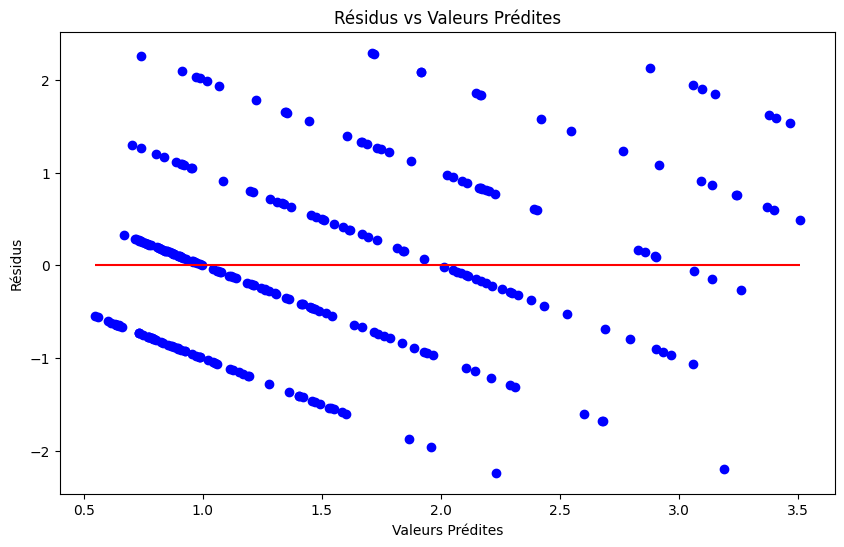

In [97]:
residuals = y_test - y_pred_best

# Tracer les résidus
plt.figure(figsize=(10,6))
plt.scatter(y_pred_best, residuals, color='blue')
plt.hlines(y=0, xmin=min(y_pred_best), xmax=max(y_pred_best), colors='red')
plt.xlabel('Valeurs Prédites')
plt.ylabel('Résidus')
plt.title('Résidus vs Valeurs Prédites')
plt.show()